In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,5)})

import pandas as pd
import pingouin as pg # this one is for stats on dataframes
pd.options.mode.chained_assignment = None  # don't try this at home
from scipy import stats

In [2]:
# If you're running on Windows, uncomment the lines below 
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

# Toy examples using the data of the braindish paper 
Data : https://osf.io/5u6qv/ (unzip the code and data in two separate folders)

Paper : https://www.sciencedirect.com/science/article/pii/S0896627322008066#section-cited-by

## If you have the courage to look at the original code, you can see it has been written by biologists
So rather than going through everything, we will only be trying to reproduce a handful of figures from the paper, namely those that are relevant for a modeling project : 
* Comparison of spiking activity over days from mouse and human neurons (Figure 3B,C,D + 3E,F,G)
* Pong performance, in terms of rally length, aces and long rallies for different paradigms (Figure 5B,C,D,E) + hits per minutes (Figure 5F)
* Input output neurons correlations and changes during gameplay (basically Figure 7 A,B,C,D + E + F)
* Spiking activity vs pong performance correlations (Figure 8 A-D)

The stats aren't included (with some exception), as these are mostly boring scipy.stats tests that you are all probably familiar with. 

Ping me on Slack if you're interested to have an extra session about, the importance of feedback in the entire learning process system (Figure 6C,D,E,F,G,H), as I feel it's something we don't really care about in possible Telluride projects.

### / ! \ Disclaimer : Some (all) code comments might have been (definitely are) generated by ChatGPT4

# 1/ Comparison of spiking activity from mouse and human neurons 
This is Figure 3B,C,D + 3E,F,G in the paper, and just shows you how to get some spikes from the .pkl files. This one has no code so I sort of reverse-engineered as best as I could from the data structure and the usual way electrophysiologist package those things

In [3]:
df = pd.read_pickle('../data/spike_trains_all.pkl')

In [4]:
df

,chip_id,session,date,tag,spike_times
0,11570,0,2021-06-23,GFP_rate_code_reseed,"{'channel_0': [2398, 8263, 19925, 32218, 92690..."
1,11570,0,2021-06-24,GFP_rate_code_reseed,"{'channel_0': [2526, 8389, 26300, 39775, 92730..."
2,11570,0,2021-06-25,GFP_rate_code_reseed,"{'channel_0': [5716, 11585, 17476, 36295, 2008..."
3,11597,0,2021-06-03,GFP_low_test_rate_code_random_3,"{'channel_0': [2520, 26318, 39789, 5345354, 59..."
4,11597,0,2021-06-23,GFP__rate_code_reseed,"{'channel_0': [2524, 32616, 2925917, 5163582, ..."
...,...,...,...,...,...
350,9501i,4,2021-04-27,prim_test_rate_code,"{'channel_0': [5702, 36546, 95632, 213362, 843..."
351,11609,6,2021-06-25,GFP_rate_code_reseed,"{'channel_0': [0, 1292051, 7025876, 10061760, ..."
352,12265,6,2021-06-21,ngn2_test_rate_code_random_3_reseed,"{'channel_0': [21839, 24583, 26623, 35233, 414..."
353,11609,8,2021-06-25,GFP_rate_code_reseed,"{'channel_0': [0, 1977047, 2829626, 7680739, 8..."


In [5]:
one_recording = df.iloc[0]['spike_times']

In [6]:
print('This is a %s' % type(one_recording))
print('Channels range are %s to %s' % (list(one_recording.keys())[0], list(one_recording.keys())[-1]))

This is a <class 'dict'>
Channels range are channel_0 to channel_1023


In [7]:
# we are civilized people, let's convert this into a numpy array instead 
sampling_freq = 20000 # from the paper, methods, "dishbrain software platform"
object_array = np.array([np.array(v)/sampling_freq for v in one_recording.values()], dtype=object)

In [8]:
max(max(arr) for arr in object_array) # this is the largest timestep of recording

1200.00085

In [9]:
1200/60 # 20 minutes sounds about right given the paper

20.0

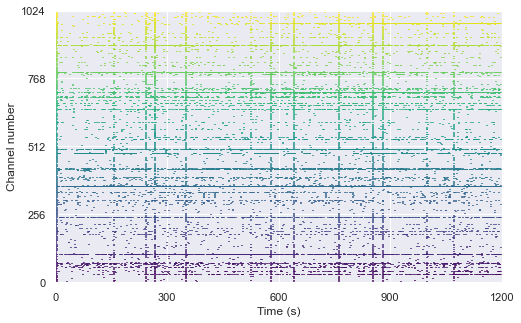

In [10]:
# Lo and behold, what an electrophysiologist spend their day doing
fig, ax = plt.subplots(figsize = (8,5))

# Plot each channel's spiketimes
for i in range(len(object_array)):
    color = plt.cm.viridis(i / len(object_array))  # choose color from colormap, viridis
    plt.eventplot(object_array[i], lineoffsets=i, colors=color)

# Show the plot
ax.set_xticks(np.linspace(0, 1200,5))
ax.set_yticks(np.linspace(0, 1024, 5))
ax.set_xlim(0,1200)
ax.set_ylim(0,1024)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channel number')
plt.show()

# 2/ Pong performance 
This is Figure 5B,C,D, E + 5F in the paper, and introduces the code to measure how good is the dish at playing pong

In [11]:
df = pd.read_pickle('../data/in_vitro_cells_sentience_main_df.pkl')
print(df.tag.unique())

hmdf = df[['group', 'elapse_minute_rounded', 'half', 'hit_count', 'count', 'ace', 'long_rally']].copy()
hmdf['hit_count'] = np.where(hmdf['hit_count'] > 4, 5, hmdf['hit_count'])
hmdf

['low_test_rate_code' 'low_test_rate_code_3' 'prim_rate_code_crecontrol'
 'prim_test_rate_code' 'prim_test_rate_code_random_3'
 'ctl_test_rate_code_3' 'ctl_test_reseed'
 'GFP_low_test_rate_code_random_3' 'GFP_predictable_stim_test'
 'GFP_predictable_stim_test_no_random_3' 'GFP_test_reseed'
 'tdt_predictable_stim_test_no_random_3'
 'in-silico_ratecode_spikes_reseed']


,group,elapse_minute_rounded,half,hit_count,count,ace,long_rally
0,0,0,0,2.0,1,0,0
1,0,0,0,0.0,1,1,0
2,0,0,0,0.0,1,1,0
3,0,0,0,1.0,1,0,0
4,0,1,0,0.0,1,1,0
...,...,...,...,...,...,...,...
34041,4,19,1,0.0,1,1,0
34042,4,19,1,0.0,1,1,0
34043,4,19,1,0.0,1,1,0
34044,4,19,1,0.0,1,1,0


In [12]:
# Group the dataframe df by several columns and compute the mean for each group
df2 = df.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half', 'elapse_minute_rounded']).mean()

# Reset the index of df2 which currently is a MultiIndex due to the groupby operation
df4 = df2.reset_index()

# Group df4 by several columns (excluding 'elapse_minute_rounded') and compute the mean for each new group
df5 = df4.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half']).mean()

# Reset the index of df5 which currently is a MultiIndex due to the groupby operation
df4 = df5.reset_index()

# Create a new column 'id' by concatenating 'chip_id', 'date', and 'session_num' as strings
df4["id"] = ((df4['chip_id']).astype(str)) + ((df4['date']).astype(str)) +((df4['session_num']).astype(str))

# Initialize a new column 'group_name' with the value 99 for all rows
df4['group_name'] = 99

# Assign string names to each group using the 'group' column. The np.where() function checks each condition and assigns the corresponding group name
df4['group_name'] = np.where((df4['group']== 0), "MCC", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 1), "CTL", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 2), "HCC", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 3), "RST", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 4), "IS", df4['group_name'])


In [13]:
df4['%long_rally'] = df4['long_rally']*100
df4['%ace'] = df4['ace']*100

#### 5B : Length of Rallies (how many times the ball bounces back and forth)

C:\Users\skorm\AppData\Local\Temp\ipykernel_3764\3539497668.py:19: UserWarning: Legend does not support handles for int instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend([0, 1], ["0-5", "6-20"])


(0.0, 2.0)

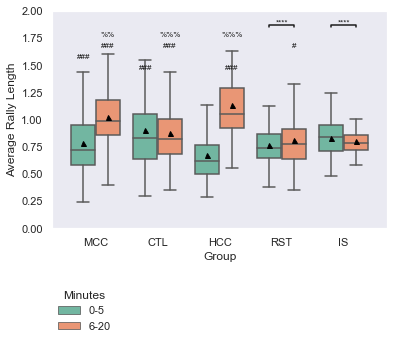

In [14]:
#box plot for hit counts

labels = df4.group_name.unique()
x_pos = np.arange(len(labels))
x = df4['group_name']
y = df4['hit_count']
hue = df4['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Pong Performance over \n Time With All Features')
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
y, h, col = 1.85, 0.02, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups
plt.plot([x30, x30, x31, x31], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x30 + x31)/2), y+ h, "****", ha='center', va='bottom', color=col,fontsize=8)
plt.plot([x40, x40, x41, x41], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x40 + x41)/2), y+ h, "****", ha='center', va='bottom', color=col,fontsize=8)
#Plot differences between groups time 2
plt.text(x00, y-.3, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x10, y-.4, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x01, y-.2, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-.2, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x21, y-.4, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x01, y-.1, "%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-.1, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x21, y-.1, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x31, y-.2, "#", ha='center', va='bottom', color=col,fontsize=8)

# Plot extra legend
#plt.text(5.5, 1.38, "%=p<0.001 \n vs MCC", ha='center', va='bottom', color=col)
#plt.text(5.5, 1.15, "#=p<0.001 \n vs HCC", ha='center', va='bottom', color=col)
#plt.text(5.5, .92, "^=p<0.01  \n vs CTL", ha='center', va='bottom', color=col)


ax.set_ylim([0, 2])
# #= HCC
# % = MCC
#! = CTL
# @ = Rest

#### 5C : % aces (how many times the dish fails to intercept the ball on serve)

C:\Users\skorm\AppData\Local\Temp\ipykernel_3764\1776193428.py:19: UserWarning: Legend does not support handles for int instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend([0, 1], ["0-5", "6-20"])


(-2.0, 80.0)

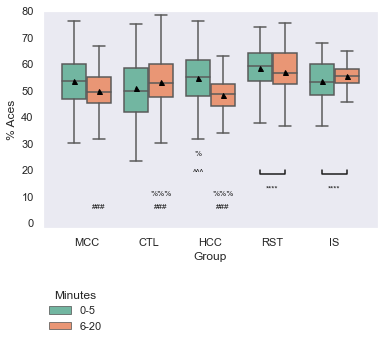

In [15]:
#box plot for aces

labels = df4.group_name.unique()
x_pos = np.arange(len(labels))
x = df4['group_name']
y = df4['%ace']
hue = df4['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Pong Performance over Time With All Features')
ax.set_ylabel('% Aces')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
#ax.set_ylim([0, 2.5])
y, h, col = 20, -1.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups
plt.plot([x30, x30, x31, x31], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x30 + x31)/2), y-8, "****", ha='center', va='bottom', color=col,fontsize=8)
plt.plot([x40, x40, x41, x41], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x40 + x41)/2), y-8, "****", ha='center', va='bottom', color=col,fontsize=8)
#Plot differences between groups time 2
plt.text(x20, y+5, "%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x20, y-2, "^^^", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x21, y-15, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-15, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x01, y-15, "###", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x21, y-10, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y-10, "%%%", ha='center', va='bottom', color=col,fontsize=8)


ax.set_ylim([-2, 80])
# #= HCC
# % = MCC
#^ = CTL
# @ = IS

#### 5D : % long rallies (3 bounces back and forth)

C:\Users\skorm\AppData\Local\Temp\ipykernel_3764\305744530.py:19: UserWarning: Legend does not support handles for int instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend([0, 1], ["0-5", "6-20"])


Text(2.2, 32.5, '%%%')

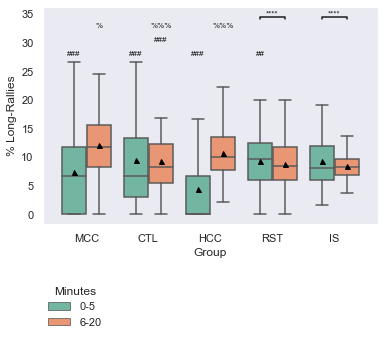

In [16]:
#box plot for long rallies

labels = df4.group_name.unique()
x_pos = np.arange(len(labels))
x = df4['group_name']
y = df4['%long_rally']
hue = df4['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Pong Performance over Time With All Features')
ax.set_ylabel('% Long-Rallies')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
#ax.set_ylim([0, 2.5])
y, h, col = 30, 0.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups
plt.plot([x30, x30, x31, x31], [y+4, y+h+4, y+h+4, y+4], lw=1.5, c=col)
plt.text(((x30 + x31)/2), y+ h+4, "****", ha='center', va='bottom', color=col,fontsize=8)
plt.plot([x40, x40, x41, x41], [y+4, y+h+4, y+h+4, y+4], lw=1.5, c=col)
plt.text(((x40 + x41)/2), y+ h+4, "****", ha='center', va='bottom', color=col,fontsize=8)
#Plot differences between groups time 2


plt.text(x00, y-2.5, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x10, y-2.5, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x20, y-2.5, "###", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x30, y-2.5, "##", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x11, y, "###", ha='center', va='bottom', color=col,fontsize=8)

plt.text(x01, y+2.5, "%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x11, y+2.5, "%%%", ha='center', va='bottom', color=col,fontsize=8)
plt.text(x21, y+2.5, "%%%", ha='center', va='bottom', color=col,fontsize=8)

#ax.set_ylim([-2, 40])
# These are codes on the figure for the stats comparison
# #= HCC
# % = MCC
#^ = CTL
# @ = Rest

# 3/ Input out correlations and changes during the gamplay
This is Figure 7A,B,C,D + E + F in the paper, tells you how to get spikes from different dish regions (sensory versus motor)

In [17]:
Corrdf = pd.read_pickle('../data/spikedatacorrsall100ms.pkl') # this is a 500mb pickle, can take a while

In [18]:
# This is a mask that basically gets cells that are normal (i.e. not used in supplementary figure controls) and of human origin
Corrdf['cell_type']= "None" # this is a placeholder
Corrdf['cell_type']= np.where((Corrdf['tag'].str.contains('GFP', case = False) | Corrdf['tag'].str.contains('ngn2', case = False) |
                        (Corrdf['tag'].str.contains('tdt', case = False))), "Human", Corrdf['cell_type'])

### Sensory vs Motor during rest (i.e. no pong)

In [19]:
# Create a copy of the original DataFrame
cutmeancorr = Corrdf

# Update 'group' column: where group is either 0 or 2, set it as 1
cutmeancorr['group'] = np.where((cutmeancorr['group'] == 0) | (cutmeancorr['group'] == 2), 1, cutmeancorr['group'])

# Update 'group' column: where group is 3 and minute is above 10, set it as 4
cutmeancorr['group'] = np.where((cutmeancorr['group'] == 3) & (cutmeancorr['minute'] > 10), 4, cutmeancorr['group'])

# Remove rows where group is equal to 4
cutmeancorr = cutmeancorr[cutmeancorr.group  != 4]

# Create a new column 'normevents' as the difference between 'events' and the mean of 'NormHzSensory', 'NormHzmotor1', and 'NormHzmotor2'
cutmeancorr['normevents'] = cutmeancorr['events'] - (((cutmeancorr['NormHzSensory']) + (cutmeancorr['NormHzmotor1']) + (cutmeancorr['NormHzmotor2']))/3)

# Group by 'cell_type', 'chip_id', 'date', 'session', 'minute' and calculate mean for each group
meancorr = cutmeancorr.groupby(['cell_type', 'chip_id', 'date', 'session', 'minute']).mean()

# Reset the index of the DataFrame
meancorr = meancorr.reset_index()

# Create two new DataFrames, one excluding group 3 and another one only containing group 3
expmeancorr = meancorr[meancorr.group  != 3]
restmeancorr = meancorr[meancorr.group  == 3]

In [20]:
# Apply Z-score normalization to 'NormHzSensory' column
restmeancorr['ZNormHzSensory'] = stats.zscore(restmeancorr['NormHzSensory'])

# Convert Z-score values of 'NormHzSensory' to absolute values
restmeancorr['ZNormHzSensory'] = restmeancorr['ZNormHzSensory'].abs()

# Filter out rows where the absolute Z-score of 'NormHzSensory' is greater than 3
fil_restmeancorr = restmeancorr[restmeancorr.ZNormHzSensory  <= 3]

# Apply Z-score normalization to 'NormHzmotor1' column in the filtered DataFrame
fil_restmeancorr['ZNormHzmotor1'] = stats.zscore(fil_restmeancorr['NormHzmotor1'])

# Convert Z-score values of 'NormHzmotor1' to absolute values
fil_restmeancorr['ZNormHzmotor1'] = fil_restmeancorr['ZNormHzmotor1'].abs()

# Filter out rows where the absolute Z-score of 'NormHzmotor1' is greater than 3
fil_restmeancorr = fil_restmeancorr[fil_restmeancorr.ZNormHzmotor1  <= 3]

# Apply Z-score normalization to 'NormHzmotor2' column in the filtered DataFrame
fil_restmeancorr['ZNormHzmotor2'] = stats.zscore(fil_restmeancorr['NormHzmotor2'])

# Convert Z-score values of 'NormHzmotor2' to absolute values
fil_restmeancorr['ZNormHzmotor2'] = fil_restmeancorr['ZNormHzmotor2'].abs()

# Filter out rows where the absolute Z-score of 'NormHzmotor2' is greater than 3
fil_restmeancorr = fil_restmeancorr[fil_restmeancorr.ZNormHzmotor2  <= 3]

In [21]:
# As stated in the paper, only 1024 electrodes are recorded at a time 
fil_restmeancorr['Sensory']= (fil_restmeancorr['NormHzSensory']*626) # 626 are sensory
fil_restmeancorr['M1']= (fil_restmeancorr['NormHzmotor1']*198) # the rest are motor
fil_restmeancorr['M2']= (fil_restmeancorr['NormHzmotor2']*200)

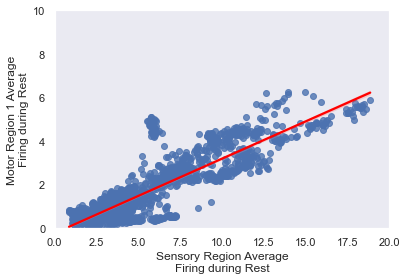

In [22]:
x = fil_restmeancorr['Sensory']
y = fil_restmeancorr['M1']
f, ax = plt.subplots()
sns.regplot(x=x, y=y, line_kws={"color": "red"})
ax.set_xlim([0, 20])
ax.set_ylim([0, 10])
ax.set_ylabel('Motor Region 1 Average\nFiring during Rest')
ax.set_xlabel('Sensory Region Average\nFiring during Rest')
ax.grid(False)

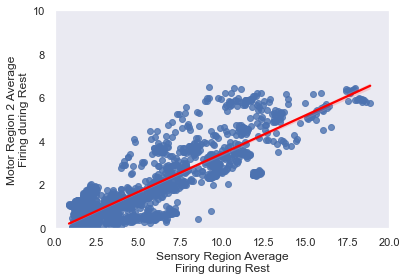

In [23]:
x = fil_restmeancorr['Sensory']
y = fil_restmeancorr['M2']
f, ax = plt.subplots()
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
ax.set_xlim([0, 20])
ax.set_ylim([0, 10])
ax.set_ylabel('Motor Region 2 Average\nFiring during Rest')
ax.set_xlabel('Sensory Region Average\nFiring during Rest')
ax.grid(False)

In [24]:
pg.pairwise_corr(fil_restmeancorr, method='spearman', columns=['NormHzmotor1', 'NormHzmotor2', 'NormHzSensory']).round(3)

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,NormHzmotor1,NormHzmotor2,spearman,two-sided,2360,0.803,"[0.79, 0.82]",0.0,1.0
1,NormHzmotor1,NormHzSensory,spearman,two-sided,2360,0.745,"[0.73, 0.76]",0.0,1.0
2,NormHzmotor2,NormHzSensory,spearman,two-sided,2360,0.686,"[0.66, 0.71]",0.0,1.0


### Sensory vs Motor during activity (i.e. pong)

In [25]:
# See comments from the resting conditions for more info
expmeancorr['ZNormHzSensory'] = stats.zscore(expmeancorr['NormHzSensory'])
expmeancorr['ZNormHzSensory'] = expmeancorr['ZNormHzSensory'].abs()
fil_expmeancorr = expmeancorr[expmeancorr.ZNormHzSensory  <= 3]
fil_expmeancorr['ZNormHzmotor1'] = stats.zscore(fil_expmeancorr['NormHzmotor1'])
fil_expmeancorr['ZNormHzmotor1'] = fil_expmeancorr['ZNormHzmotor1'].abs()
fil_expmeancorr = fil_expmeancorr[fil_expmeancorr.ZNormHzmotor1  <= 3]
fil_expmeancorr['ZNormHzmotor2'] = stats.zscore(fil_expmeancorr['NormHzmotor2'])
fil_expmeancorr['ZNormHzmotor2'] = fil_expmeancorr['ZNormHzmotor2'].abs()
fil_expmeancorr = fil_expmeancorr[fil_expmeancorr.ZNormHzmotor1  <= 3]

In [26]:
fil_expmeancorr['Sensory']= (fil_expmeancorr['NormHzSensory']*626)
fil_expmeancorr['M1']= (fil_expmeancorr['NormHzmotor1']*198)
fil_expmeancorr['M2']= (fil_expmeancorr['NormHzmotor2']*200)

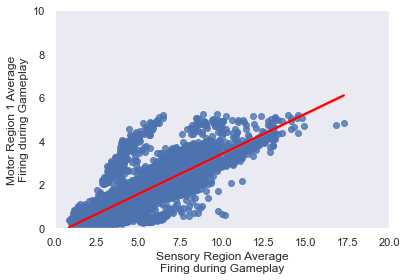

In [27]:
x = fil_expmeancorr['Sensory']
y = fil_expmeancorr['M1']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
ax.set_xlim([0, 20])
ax.set_ylim([0, 10])
ax.set_ylabel('Motor Region 1 Average\nFiring during Gameplay')
ax.set_xlabel('Sensory Region Average\nFiring during Gameplay')
ax.grid(False)

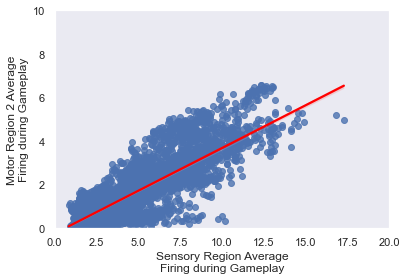

In [28]:
x = fil_expmeancorr['Sensory']
y = fil_expmeancorr['M2']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
ax.set_xlim([0, 20])
ax.set_ylim([0, 10])
ax.set_ylabel('Motor Region 2 Average\nFiring during Gameplay')
ax.set_xlabel('Sensory Region Average\nFiring during Gameplay')
ax.grid(False)

In [29]:
pg.pairwise_corr(fil_expmeancorr, method='spearman', columns=['NormHzmotor1', 'NormHzmotor2', 'NormHzSensory']).round(3)

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,NormHzmotor1,NormHzmotor2,spearman,two-sided,7234,0.808,"[0.8, 0.82]",0.0,1.0
1,NormHzmotor1,NormHzSensory,spearman,two-sided,7234,0.777,"[0.77, 0.79]",0.0,1.0
2,NormHzmotor2,NormHzSensory,spearman,two-sided,7234,0.696,"[0.68, 0.71]",0.0,1.0


#### And now the cross correlation

In [30]:
# we merge the pong play and rest sessions
fil_meancorr = pd.concat([fil_expmeancorr, fil_restmeancorr], join = 'inner', axis = 0) 

# Just copying along columns
d = {'group': fil_meancorr[('group')], 'cell_type': fil_meancorr[('cell_type')], 'minute': fil_meancorr[('minute')], 'session': meancorr[('session')],
     'chip_id': fil_meancorr[('chip_id')], 'date': fil_meancorr[('date')], 
     'pmotor1Corr': fil_meancorr[('pmotor1Corr')], 'pmotor2Corr': fil_meancorr[('pmotor2Corr')]}
longmeancorr = pd.DataFrame(data=d)

# This turns a wide df into a tall df, it's basically just pivoting
longmeancorr = pd.melt(longmeancorr, id_vars=['group', 'cell_type', 'chip_id', 'date', 'session', 'minute'])

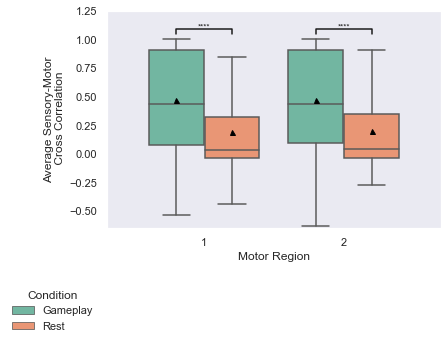

In [31]:
ax = sns.boxplot(x=longmeancorr['variable'], y=longmeancorr['value'], hue = longmeancorr['group'], palette="Set2", 
                 showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set(xlabel='Motor Region', ylabel='Average Sensory-Motor\n Cross Correlation')
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.3, -0.5), title = "Condition", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('Gameplay')
L.get_texts()[1].set_text('Rest')
ax.set_xticklabels(("1", "2"))
sns.set(style="darkgrid")
ax.grid(False)
y, h, col = 1.05, 0.04, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2

#Plot t-test between groups
plt.plot([x00, x00, x01, x01], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x00 + x01)/2), y+ h, "****", ha='center', va='bottom', color=col, fontsize=8)
plt.plot([x10, x10, x11, x11], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x10 + x11)/2), y+ h, "****", ha='center', va='bottom', color=col, fontsize=8)


ax.set_ylim([-0.65, 1.25])
plt.show()

#### And now we look at the evolution of the motor activity during rest and during gameplay

In [32]:
# Notice how this is not the same pkl file
Corrdf = pd.read_pickle('../data/spikedatacorrsall1000ms.pkl')

Corrdf['cell_type']= "None"
Corrdf['cell_type']= np.where((Corrdf['tag'].str.contains('GFP', case = False) | Corrdf['tag'].str.contains('ngn2', case = False) |
                        (Corrdf['tag'].str.contains('tdt', case = False))), "Human", Corrdf['cell_type'])

In [33]:
# Create a copy of the original DataFrame and filter out rows where 'minute' is less than or equal to 0
cutmeancorr = Corrdf[Corrdf.minute  > 0]

# Add a new column 'celltype' and initialize all its values as 0
cutmeancorr['celltype'] = 0

# Update 'celltype' column: if 'group' is 0, set 'celltype' as "Mouse", otherwise "Human"
cutmeancorr['celltype'] = np.where((cutmeancorr['group'] == 0), "Mouse", "Human")

# Update 'minute' column: if 'group' is 1, add 10 to 'minute', otherwise keep the original value
cutmeancorr['minute'] = np.where((cutmeancorr['group'] == 1), (cutmeancorr['minute']+10), cutmeancorr['minute'])

# Remove rows where group is equal to 4
cutmeancorr = cutmeancorr[cutmeancorr.group  != 4]

# Create a new column 'normevents' as the difference between 'events' and the mean of 'NormHzSensory', 'NormHzmotor1', and 'NormHzmotor2'
cutmeancorr['normevents'] = cutmeancorr['events'] - (((cutmeancorr['NormHzSensory']) + (cutmeancorr['NormHzmotor1']) + (cutmeancorr['NormHzmotor2']))/3)

# Group by 'cell_type', 'chip_id', 'date', 'session', 'minute' and calculate mean for each group
meancorr = cutmeancorr.groupby(['cell_type', 'chip_id', 'date', 'session', 'minute']).mean()

# Reset the index of the DataFrame
meancorr = meancorr.reset_index()

# Create two new DataFrames, one excluding group 3 and another one only containing group 3
expmeancorr = meancorr[meancorr.group  != 3]
restmeancorr = meancorr[meancorr.group  == 3]

# Multiply 'events' column by 100
meancorr['events'] = meancorr['events'] * 100

(5.0, 20.0)

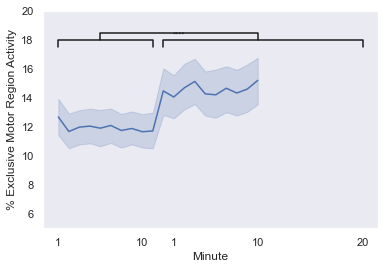

In [34]:
x = meancorr['minute']
y = meancorr['events']
#hue = data['half']
sns.set(style="darkgrid")
ax = sns.lineplot(data=meancorr, x=x, y=y, palette="Set2")
#ax.set_xticks(x_pos)
plt.xticks([1,9,12,20,30],['1','10','1','10','20'])
#ax.set_xticklabels(("STIM", "SIL", "NF", "RST"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('% Exclusive Motor Region Activity')
ax.set_xlabel('Minute')
ax.grid(False)

plt.plot([5, 5, 20, 20], [18, 18.5, 18.5, 18], lw=1.5, c='k')
plt.text(12.5, 18.2, "****", ha='center', va='bottom', color='k', fontsize=8)

plt.plot([1, 1, 10, 10], [17.5, 18, 18, 17.5], lw=1.5, c='k')

plt.plot([11, 11, 30, 30], [17.5, 18, 18, 17.5], lw=1.5, c='k')

ax.set_ylim([5, 20])

# 4/ Spiking activity vs Pong Performance correlations 
This is Figure 8A-D and ties up the entire notebook by getting data from specific neurons and correlating them with gameplay performance

#### Rally length vs Mean Firing Rate (8A) or vs Max Firing Rate (8B)

In [35]:
activitydf = pd.read_pickle('../data/spikedatacorrsall100ms.pkl')
activitydf['chip_id'] = activitydf['chip_id'].str.extract('(\d+)', expand=False)

df = pd.read_pickle('../data/in_vitro_cells_sentience_corr.pkl')
df = df.rename(columns={"elapse_minute_rounded": "minute", "session_num": "session", "elapse_seconds": "second"}, errors="raise")

In [36]:
# Convert the 'date' column in the dataframe 'df' into datetime format using pandas to_datetime function
df['date'] = pd.to_datetime(df['date'])

# Convert the 'date' column in the dataframe 'activitydf' into datetime format using pandas to_datetime function
activitydf['date'] = pd.to_datetime(activitydf['date'])

# Convert the 'session' column in the dataframe 'df' into numeric format using pandas to_numeric function
df['session'] = pd.to_numeric(df['session'])

# Convert the 'session' column in the dataframe 'activitydf' into numeric format using pandas to_numeric function
activitydf['session'] = pd.to_numeric(activitydf['session'])

# Further convert the 'session' column in the dataframe 'df' into 'int64' format
df['session'] = df['session'].astype('int64')

# Further convert the 'session' column in the dataframe 'activitydf' into 'int64' format
activitydf['session'] = activitydf['session'].astype('int64')

# Convert the 'chip_id' column in the dataframe 'df' into 'int64' format
df['chip_id'] = df['chip_id'].astype('int64')

# Convert the 'chip_id' column in the dataframe 'activitydf' into 'int64' format
activitydf['chip_id'] = activitydf['chip_id'].astype('int64')

In [37]:
# Group 'activitydf' and 'df' DataFrames by several columns and calculate the mean of each group.
meanActivitydf = activitydf.groupby(['group', 'chip_id', 'date', 'session', 'minute']).mean()
meanActivitydf = meanActivitydf.reset_index()
meanGamedf = df.groupby(['group','chip_id', 'date', 'session', 'minute']).mean()
meanGamedf = meanGamedf.reset_index()

# Merge 'meanGamedf' and 'meanActivitydf' on certain columns.
alldf = meanGamedf.merge(meanActivitydf, how='outer', on = ['group', 'chip_id', 'date', 'session', 'minute'])

# Remove some groups and minutes from 'alldf'.
alldf = alldf[alldf.group  != 4]
alldf = alldf[alldf.group  != 1]
alldf = alldf[alldf.group  != 3]
alldf = alldf[alldf.minute  != 0]

# Compute new variables based on existing ones in 'alldf'.
alldf['firingratio'] = alldf['NormHzmotor1']/alldf['NormHzmotor2']
alldf['absfiringratio'] = (abs(alldf['firingratio']-1))
alldf['allcrossconnect'] = alldf['pmotor1Corr']*alldf['pmotor2Corr']
alldf['crossconnect'] = alldf['pmotor1Corr']*alldf['pmotor2Corr']*alldf['pmotorsCorr']

# Compute new variables based on existing ones in 'alldf' and assign them to 'alldf1'.
alldf1 = alldf
# Compute new variables based on existing ones in 'alldf1'.
alldf1['normdct01_firing'] = alldf1['dct01_firing']/alldf1['mean_firing']
alldf1['normdct10_firing'] = alldf1['dct10_firing']/alldf1['mean_firing']
alldf1['normdct02_firing'] = alldf1['dct02_firing']/alldf1['mean_firing']
alldf1['normdct20_firing'] = alldf1['dct20_firing']/alldf1['mean_firing']
alldf1['normdct01_firing'] =alldf1['normdct01_firing'].abs()
alldf1['normdct10_firing'] =alldf1['normdct10_firing'].abs()
alldf1['normdct02_firing'] =alldf1['normdct02_firing'].abs()
alldf1['normdct20_firing'] =alldf1['normdct20_firing'].abs()
alldf1['Sensoryfiring']=(alldf1['NormHzSensory']*626)
alldf1['Motor1Firing']=(alldf1['NormHzmotor1']*198)
alldf1['Motor2Firing']=(alldf1['NormHzmotor2']*200)

# Apply Z-score normalization on various variables in 'alldf1' and filter out values that are beyond 3.29 standard deviations from the mean.
# Abs is taken of z-scores to remove negative values.
for col in ['mean_firing', 'max_firing', 'NormHzSensory', 'NormHzmotor1', 'NormHzmotor2', 'pmotor1Corr', 'pmotor2Corr', 'absfiringratio', 'hit_count']:
    z_col = 'Z' + col
    alldf1[z_col] = (alldf1[col] - alldf1[col].mean())/alldf1[col].std(ddof=0) 
    alldf1[z_col] = alldf1[z_col].abs()
    alldf1 = alldf1[alldf1[z_col] <= 3.29]

# Group 'alldf1' DataFrame by several columns and calculate the mean of each group.
meanAlldf = alldf1.groupby(['group','chip_id', 'date', 'session']).mean()
meanAlldf = meanAlldf.reset_index()


In [38]:
exp_corr2 = meanAlldf[((meanAlldf.group == 0) | (meanAlldf.group == 2))]
pg.pairwise_corr(exp_corr2, method='pearson', columns=['hit_count']).round(3)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,hit_count,group,pearson,two-sided,302,-0.334,"[-0.43, -0.23]",0.000,3.207e+06,1.000
1,hit_count,chip_id,pearson,two-sided,302,0.161,"[0.05, 0.27]",0.005,3.696,0.805
2,hit_count,session,pearson,two-sided,302,0.064,"[-0.05, 0.18]",0.270,0.132,0.197
3,hit_count,minute,pearson,two-sided,302,-0.001,"[-0.11, 0.11]",0.981,0.072,0.050
4,hit_count,second_x,pearson,two-sided,302,0.004,"[-0.11, 0.12]",0.947,0.072,0.050
5,hit_count,mean_firing,pearson,two-sided,302,0.240,"[0.13, 0.34]",0.000,515.792,0.989
6,hit_count,max_firing,pearson,two-sided,302,0.231,"[0.12, 0.33]",0.000,252.071,0.983
7,hit_count,var_firing,pearson,two-sided,302,0.276,"[0.17, 0.38]",0.000,9664.868,0.998
8,hit_count,norm_firing,pearson,two-sided,302,0.307,"[0.2, 0.41]",0.000,1.781e+05,1.000
9,hit_count,q95_firing,pearson,two-sided,302,0.211,"[0.1, 0.32]",0.000,62.24,0.959


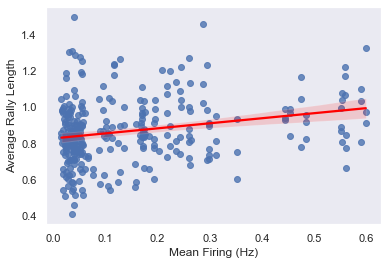

In [39]:
x = exp_corr2['mean_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Mean Firing (Hz)')
ax.grid(False) 

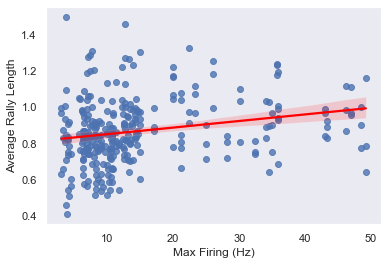

In [40]:
x = exp_corr2['max_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Max Firing (Hz)')
ax.grid(False)

#### Rally Length vs Sensory-Motor1 correlation (8C) or vs Sensory-Motor2 correlation (8D)

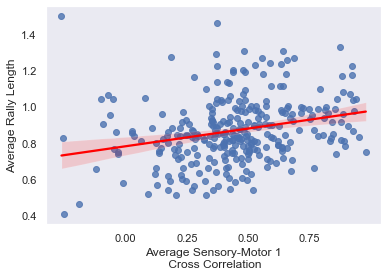

In [41]:
x = exp_corr2['pmotor1Corr']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
plt.xticks([0.00, 0.25, 0.50, 0.75])
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Average Sensory-Motor 1\n Cross Correlation')
ax.grid(False)

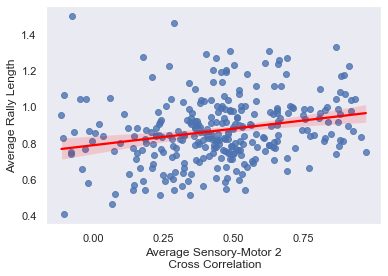

In [42]:
x = exp_corr2['pmotor2Corr']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
plt.xticks([0.00, 0.25, 0.50, 0.75])
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Average Sensory-Motor 2\n Cross Correlation')
ax.grid(False)

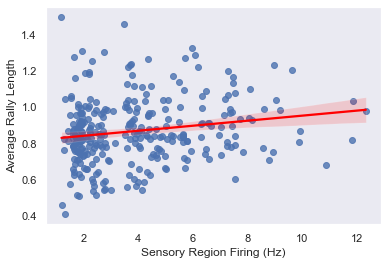

In [43]:
x = exp_corr2['Sensoryfiring']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Sensory Region Firing (Hz)')
ax.grid(False)

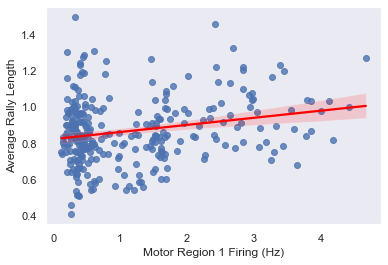

In [44]:
x = exp_corr2['Motor1Firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Motor Region 1 Firing (Hz)')
ax.grid(False)

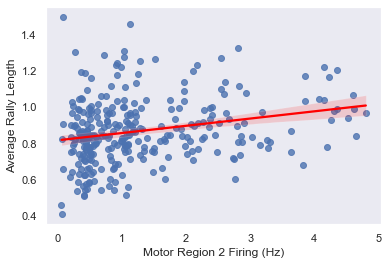

In [45]:
x = exp_corr2['Motor2Firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Motor Region 2 Firing (Hz)')
ax.grid(False)